In [9]:
text = open("_chat.txt", "r") 

In [34]:
print(text)

<_io.TextIOWrapper name='_chat.txt' mode='r' encoding='UTF-8'>


In [318]:
import re
import pandas as pd
import matplotlib as plt

In [210]:
def startsWithDate(s):
    pattern = '^\[([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]):([0-9][0-9])\] '
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [277]:

def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '^([\w]+[\s]+\(+[\w]+\)+):',       # First Name + Bracket + Last name + Bracket
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [299]:
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    splitLine = line.split('] ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0].split('[')[1] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [300]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/shubhamgoyal/Documents/homepage/_chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:

    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

In [301]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

,Date,Time,Author,Message
0,06/12/20,13:03:21,Anchal (Jp),Hey
1,06/12/20,13:03:25,Anchal (Jp),This is Anchal
2,06/12/20,13:03:51,Anchal (Jp),Wait I'll send you the location in 5
3,06/12/20,13:11:14,Shubham Goyal,Cool
4,06/12/20,13:16:59,Anchal (Jp),‎Location https://maps.google.com/?q=26.88800...


In [302]:
df.describe()

,Date,Time,Author,Message
count,4102,4102,4102,4102
unique,74,3895,2,3475
top,20/12/20,23:31:40,Anchal (Jp),Lol
freq,218,4,2288,64


<AxesSubplot:>

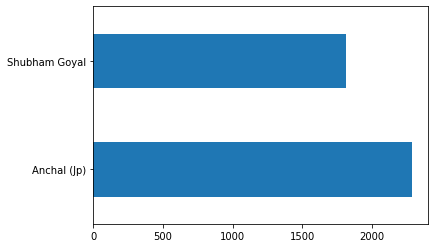

In [310]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_10_author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis


In [315]:
df['Lol_Count']=df['Message'].apply(lambda s : s.count('lol'))+df['Message'].apply(lambda s : s.count('Lol'))+df['Message'].apply(lambda s : s.count('LOL'))
df.head()

,Date,Time,Author,Message,Lol_Count
0,06/12/20,13:03:21,Anchal (Jp),Hey,0
1,06/12/20,13:03:25,Anchal (Jp),This is Anchal,0
2,06/12/20,13:03:51,Anchal (Jp),Wait I'll send you the location in 5,0
3,06/12/20,13:11:14,Shubham Goyal,Cool,0
4,06/12/20,13:16:59,Anchal (Jp),‎Location https://maps.google.com/?q=26.88800...,0


In [316]:
df['Lol_Count'].sum()

162

Text(0, 0.5, 'Authors')

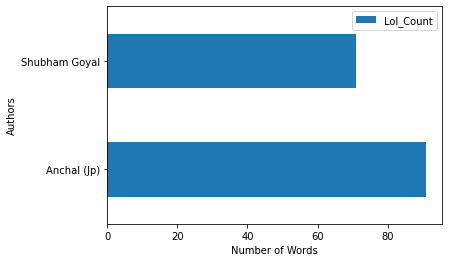

In [322]:
total_word_count_grouped_by_author = df[['Author', 'Lol_Count']].groupby('Author').sum()
total_word_count_grouped_by_author.plot.barh()
plt.pyplot.xlabel('Number of Words')
plt.pyplot.ylabel('Authors')

In [323]:
total_word_count_grouped_by_author

,Lol_Count
Author,
Anchal (Jp),91
Shubham Goyal,71


Text(0, 0.5, 'Date')

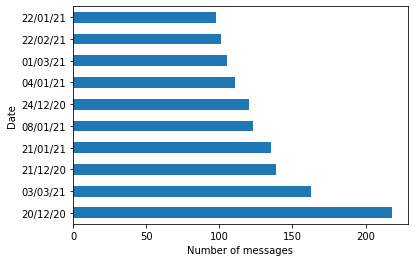

In [325]:
df['Date'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.pyplot.xlabel('Number of messages')
plt.pyplot.ylabel('Date')

In [288]:
conversationPath = '/Users/shubhamgoyal/Documents/homepage/_chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    line=fp.readline()
    line=fp.readline()
    line=fp.readline()
    line=fp.readline()

In [289]:
line

"[06/12/20, 13:03:51] Anchal (Jp): Wait I'll send you the location in 5\n"

In [298]:
dateTime = splitLine[0].split('[')[1]
dateTime

'06/12/20, 13:03:51'

In [290]:
splitLine=line.split('] ')

In [291]:
message=' '.join(splitLine[1:])

In [292]:
pattern = '^\[([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]):([0-9][0-9])\] '
print(re.match(pattern, line))

<re.Match object; span=(0, 21), match='[06/12/20, 13:03:51] '>


In [293]:
(message)

"Anchal (Jp): Wait I'll send you the location in 5\n"

In [243]:
splitLine = line.split() # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:])

IndentationError: unexpected indent (<ipython-input-243-3b4f1be9aeec>, line 3)